In [1]:
import os
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator
import numpy as np
import sklearn.preprocessing as skp
# from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm, trange
import torch
device = torch.device("cpu")

from utils.cstr_experiment import dXdt, dXdt_drifting, sim, get_U, format_dataset, rescale_data, graph_concentration_predictions
from utils import *
from utils.modeling import Exogenous_RkRNN, get_jacobian, mask_fn, MyCosineAnnealingWarmRestartsWithWarmup
from utils.optimizers import *

sns.set_context("talk")

results_dir = os.path.join("results", "CSTR")
os.makedirs(results_dir, exist_ok=True)
results_filename = os.path.join(results_dir, "results.h5")
# %config InlineBackend.figure_format = "svg"

logger = h5_logger(os.path.join(results_dir, "data.h5"), existing="True")
device = torch.device("cpu")

/var/folders/s5/91gspn4x2j9c_j33qvjvrlt00000gn/T/ipykernel_78162/4025618892.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Create Model, Datasets, and fit NN model

In [2]:
static_process_dir = os.path.join(results_dir, "Static Process")
os.makedirs(static_process_dir, exist_ok=True)

F = 0.6
V = 15.0
k1 = 2e-1
k2f = 5e-1
k2r = 1e-1

Caf_min = 1.0
Caf_max = 3.0

sim_minutes = 36 * 60
train_minutes = 24 * 60
val_minutes = 6 * 60
test_minutes = 6 * 60

input_horizon = 1  # Np
prediction_horizon = 60
batch_size = 100
nx = 3
nu = 1

m = Exogenous_RkRNN(nx, nu, 16)

static_model_save_path = os.path.join(static_process_dir, "constant_model.pt")

In [3]:
# training loop
if (not os.path.exists(static_model_save_path)) or (not logger.check_key("training/loss/val")):
    
    process_tspan = np.linspace(0, sim_minutes, sim_minutes+1)
    process_u = get_U(process_tspan, Caf_min, Caf_max, 5)
    process_x0 = np.array([0.33333333, 0.47851534, 0.38994523])
    process_noise = np.array([5e-4, 1e-4, 1e-4])

    sim_5_data = sim(dXdt, process_tspan, process_x0, process_u, noise=process_noise)

    Xscaler = skp.StandardScaler()
    Uscaler = skp.StandardScaler()

    train_dataset = format_dataset(sim_5_data, Xscaler, Uscaler, end_index=train_minutes, nx=nx, input_horizon=input_horizon, train=True, name="train", device=device)
    val_dataset = format_dataset(sim_5_data, Xscaler, Uscaler, begin_index=train_minutes, end_index=train_minutes + val_minutes, nx=nx, input_horizon=input_horizon, train=False, name="val", device=device)
    test_dataset = format_dataset(sim_5_data, Xscaler, Uscaler, begin_index=train_minutes + val_minutes, end_index=train_minutes + val_minutes + test_minutes, nx=nx, input_horizon=input_horizon, train=False, name="test", device=device)
    static_dataset = format_dataset(sim_5_data, Xscaler, Uscaler, begin_index=0, end_index=train_minutes + val_minutes + test_minutes, nx=nx, input_horizon=input_horizon, train=False, name="static", device=device)
    
    logger.log_dict({
        # Static Dataset
        "training/values/sim_5_data/X": sim_5_data["X"],
        "training/values/sim_5_data/U": sim_5_data["U"],
        "training/values/sim_5_data/Y": sim_5_data["Y"],
        # Scaled Values
        "training/values/train/xn_scaled": train_dataset["xn"].cpu().numpy(),
        "training/values/train/u_scaled": train_dataset["u"].cpu().numpy(),
        "training/values/train/y_scaled": train_dataset["y"].cpu().numpy(),
        "training/values/val/xn_scaled": val_dataset["xn"].cpu().numpy(),
        "training/values/val/u_scaled": val_dataset["u"].cpu().numpy(),
        "training/values/val/y_scaled": val_dataset["y"].cpu().numpy(),
        "training/values/test/xn_scaled": test_dataset["xn"].cpu().numpy(),
        "training/values/test/u_scaled": test_dataset["u"].cpu().numpy(),
        "training/values/test/y_scaled": test_dataset["y"].cpu().numpy(),
        # Unscaled Values
        "training/values/train/xn": Xscaler.inverse_transform(train_dataset["xn"].cpu().numpy().reshape(-1, nx)).reshape(train_dataset["xn"].shape),
        "training/values/train/u": Uscaler.inverse_transform(train_dataset["u"].cpu().numpy().reshape(-1, nu)).reshape(train_dataset["u"].shape),
        "training/values/train/y": Xscaler.inverse_transform(train_dataset["y"].cpu().numpy().reshape(-1, nx)).reshape(train_dataset["y"].shape),
        "training/values/val/xn": Xscaler.inverse_transform(val_dataset["xn"].cpu().numpy().reshape(-1, nx)).reshape(val_dataset["xn"].shape),
        "training/values/val/u": Uscaler.inverse_transform(val_dataset["u"].cpu().numpy().reshape(-1, nu)).reshape(val_dataset["u"].shape),
        "training/values/val/y": Xscaler.inverse_transform(val_dataset["y"].cpu().numpy().reshape(-1, nx)).reshape(val_dataset["y"].shape),
        "training/values/test/xn": Xscaler.inverse_transform(test_dataset["xn"].cpu().numpy().reshape(-1, nx)).reshape(test_dataset["xn"].shape),
        "training/values/test/u": Uscaler.inverse_transform(test_dataset["u"].cpu().numpy().reshape(-1, nu)).reshape(test_dataset["u"].shape),
        "training/values/test/y": Xscaler.inverse_transform(test_dataset["y"].cpu().numpy().reshape(-1, nx)).reshape(test_dataset["y"].shape),
    })
    
    epochs = 160
    m.to(device)
    optimizer = torch.optim.Adam(m.parameters(), lr=1e-2)
    # lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2)
    lr_scheduler = MyCosineAnnealingWarmRestartsWithWarmup(optimizer, T_0=50, T_mult=2)
    loss_fn = torch.nn.MSELoss()
    batch_size = 50
    data_indices = np.arange(0, train_dataset["y"].shape[0])
    default_rng.shuffle(data_indices)
    pbar = trange(epochs)
    
    start_time = time.time()
    for epoch in pbar:
        default_rng.shuffle(data_indices)
        batch_indices = np.array_split(data_indices, data_indices.shape[0] // batch_size)
        for batch, batch_idx in enumerate(batch_indices):
            x = train_dataset["xn"][batch_idx]
            u = train_dataset["u"][batch_idx]
            y = train_dataset["y"][batch_idx]
            optimizer.zero_grad()
            y_pred = m(x, u)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

        # validation
        with torch.no_grad():
            x = train_dataset["xn"]
            u = train_dataset["u"]
            y = train_dataset["y"]
            y_pred_train = m(x, u)
            loss = loss_fn(y_pred_train, y)
            accumulated_loss_train= loss.item()
            
            x = val_dataset["xn"]
            u = val_dataset["u"]
            y = val_dataset["y"]
            y_pred_val = m(x, u)
            loss = loss_fn(y_pred_val, y)
            accumulated_loss_val = loss.item()
        
        lr_scheduler.step()
        epoch_time = time.time() - start_time
        logger.log_dict({
            "training/loss/train": np.array([accumulated_loss_train]),
            "training/loss/val": np.array([accumulated_loss_val]),
            "training/time": np.array([epoch_time]),
            # "training/values/train/x": train_dataset['xn'].cpu().numpy(),
            # "training/values/train/u": train_dataset['u'].cpu().numpy(),
            # "training/values/train/y": train_dataset['y'].cpu().numpy(),
            "training/values/train/yp": y_pred_train.detach().cpu().numpy(),
            # "training/values/val/x": val_dataset['xn'].cpu().numpy(),
            # "training/values/val/u": val_dataset['u'].cpu().numpy(),
            # "training/values/val/y": val_dataset['y'].cpu().numpy(),
            "training/values/val/yp": y_pred_val.detach().cpu().numpy(),
            # "training/values/test/x": test_dataset['xn'].cpu().numpy(),
            # "training/values/test/u": test_dataset['u'].cpu().numpy(),
            # "training/values/test/y": test_dataset['y'].cpu().numpy(),
            "training/values/test/yp": m(test_dataset['xn'], test_dataset['u']).detach().cpu().numpy(),
        })
           
        pbar.set_description(f"Epoch {epoch+1}/{epochs}, Loss: {accumulated_loss_train:.4f}, Val Loss: {accumulated_loss_val:.4f}, Time: {epoch_time:.2f}s")
        lr_scheduler.step()
    # save model
    torch.save(m.state_dict(), static_model_save_path)
    
else:
    Xscaler = skp.StandardScaler()
    Uscaler = skp.StandardScaler()
    Xscaler.fit(logger.get_dataset("training/values/sim_5_data/Y")[0])
    Uscaler.fit(logger.get_dataset("training/values/sim_5_data/U")[0])
    
    process_tspan = np.linspace(0, sim_minutes, sim_minutes+1)
    process_u = logger.get_dataset("training/values/sim_5_data/U")[0]
    process_x0 = np.array([0.33333333, 0.47851534, 0.38994523])
    process_noise = np.array([5e-4, 1e-4, 1e-4])
    
    sim_5_data = {
        "X": logger.get_dataset("training/values/sim_5_data/Y")[0],
        "U": logger.get_dataset("training/values/sim_5_data/U")[0],
        "Y": logger.get_dataset("training/values/sim_5_data/Y")[0]
    }
    
    train_dataset = format_dataset(sim_5_data, Xscaler, Uscaler, end_index=train_minutes, nx=nx, input_horizon=input_horizon, train=True, name="train", device=device)
    val_dataset = format_dataset(sim_5_data, Xscaler, Uscaler, begin_index=train_minutes, end_index=train_minutes + val_minutes, nx=nx, input_horizon=input_horizon, train=False, name="val", device=device)
    test_dataset = format_dataset(sim_5_data, Xscaler, Uscaler, begin_index=train_minutes + val_minutes, end_index=train_minutes + val_minutes + test_minutes, nx=nx, input_horizon=input_horizon, train=False, name="test", device=device)
    static_dataset = format_dataset(sim_5_data, Xscaler, Uscaler, begin_index=0, end_index=train_minutes + val_minutes + test_minutes, nx=nx, input_horizon=input_horizon, train=False, name="static", device=device)
    
    m.load_state_dict(torch.load(static_model_save_path, map_location=device, weights_only=True))
    m.to(device)

  0%|          | 0/160 [00:00<?, ?it/s]

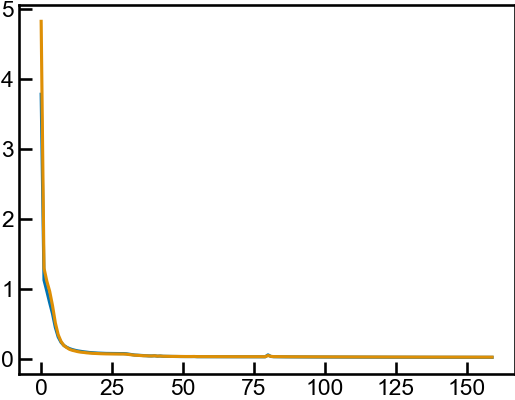

In [4]:
plt.plot(logger.get_dataset("training/loss/train"), label="Train")
plt.plot(logger.get_dataset("training/loss/val"), label="Validation")

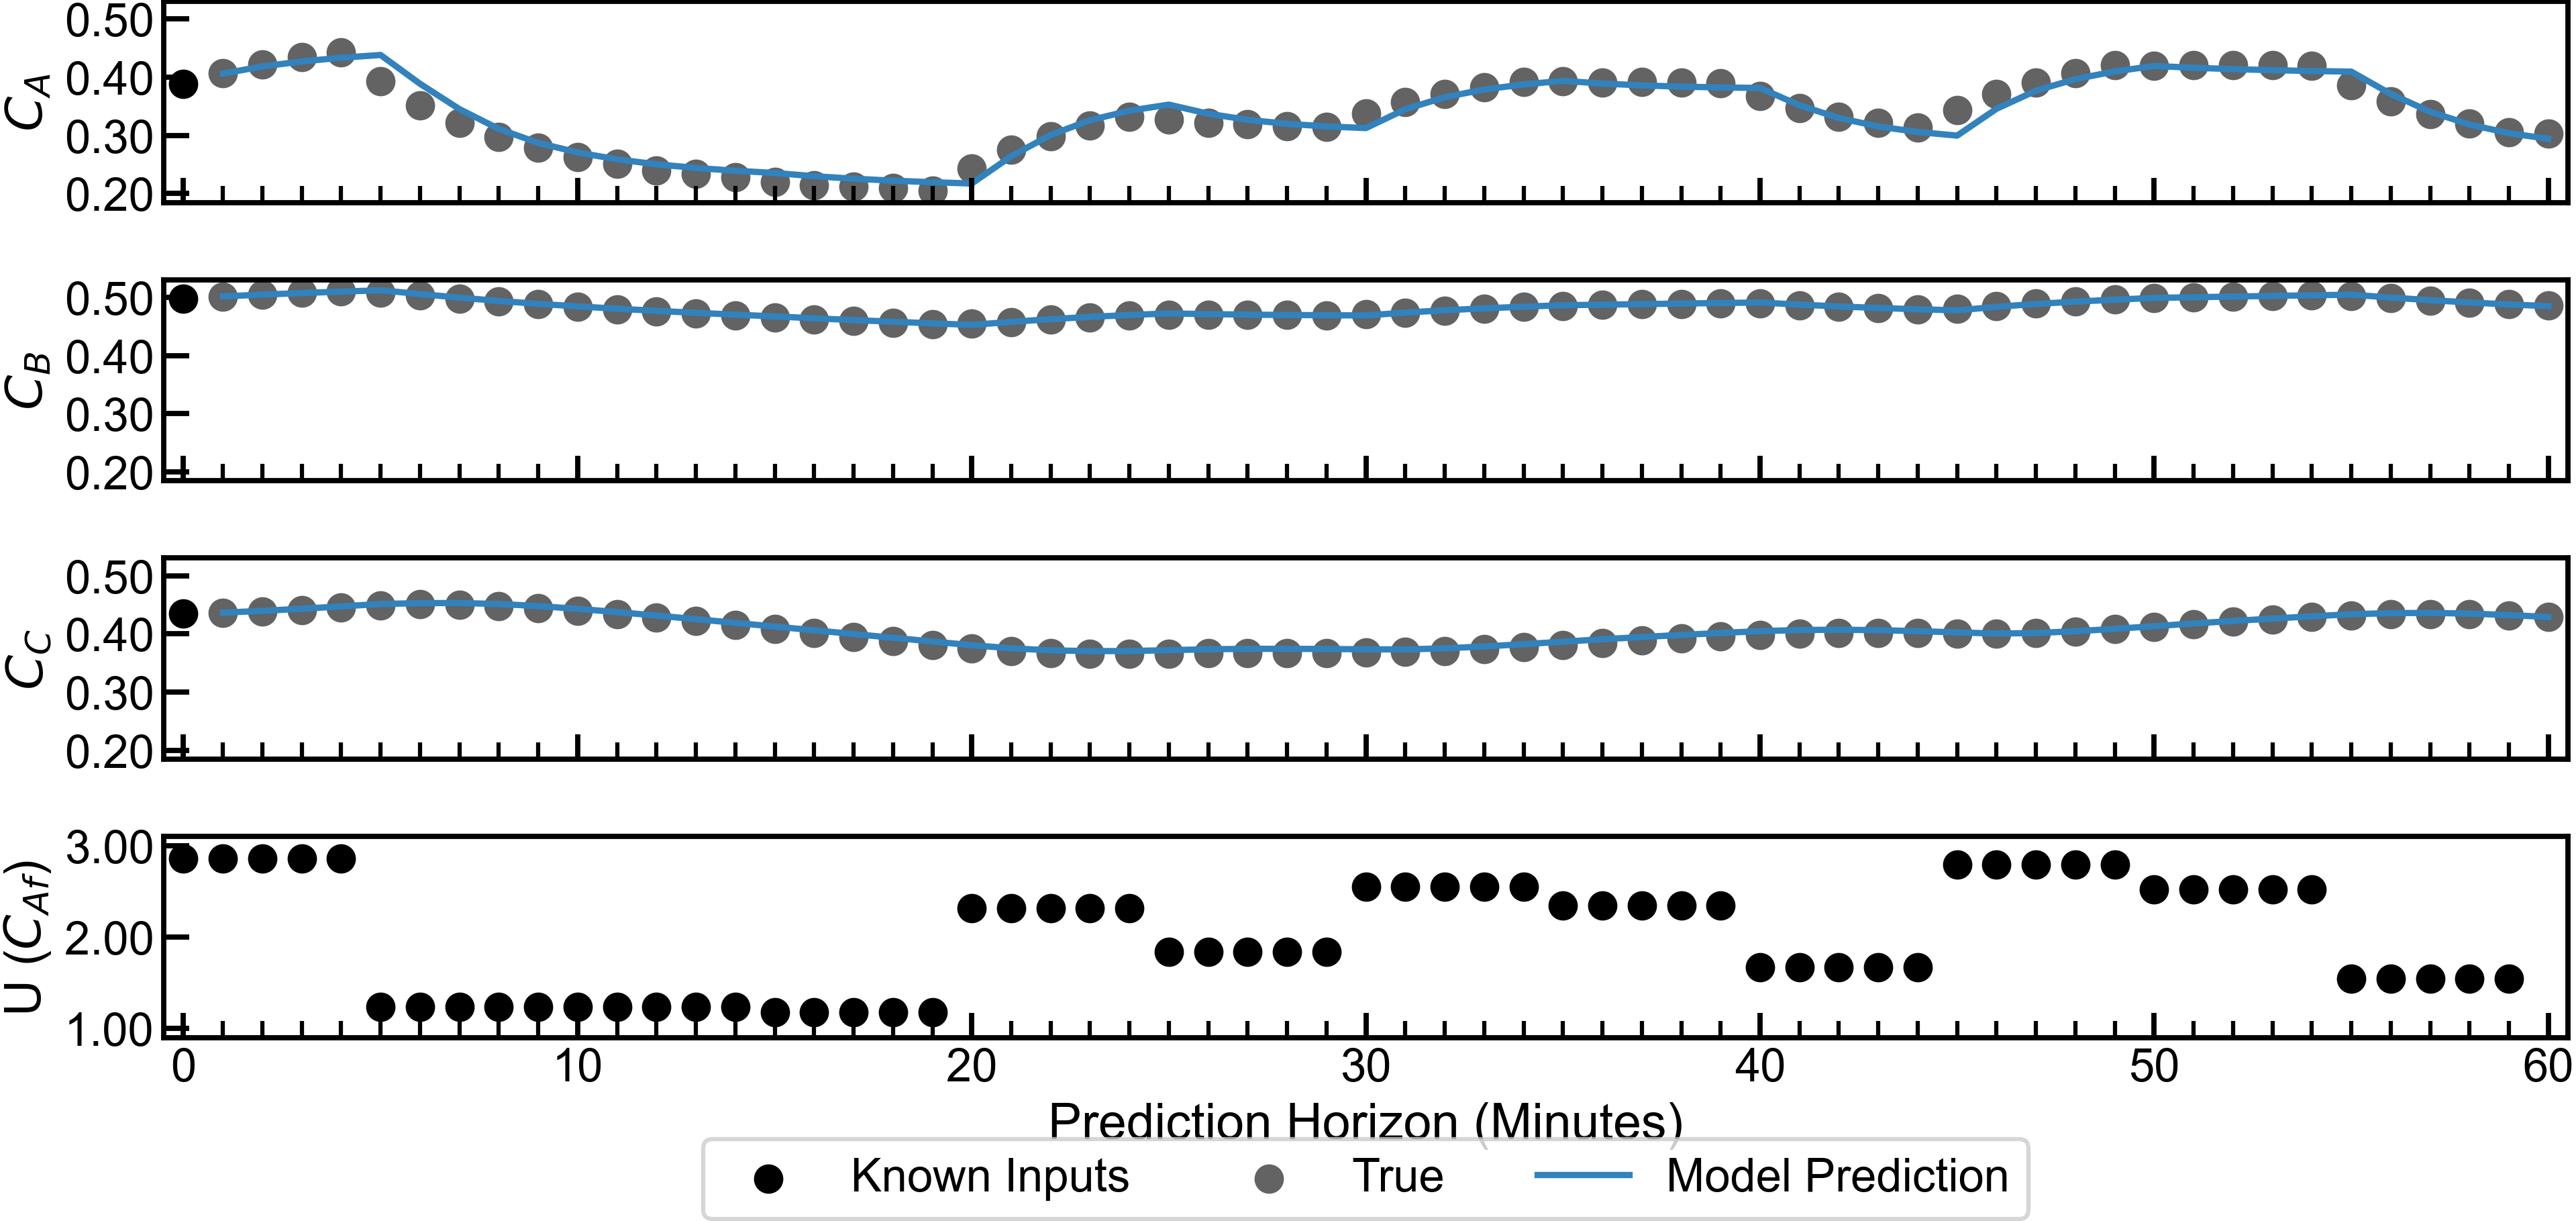

In [5]:
# Graphs of Static Model / Data
if 1:
    ### graph all data and show training, validation, and test data ###
    species_labels = [r"$C_A$", r"$C_B$", r"$C_C$"]
    y_ticks_formatter = mpl.ticker.StrMethodFormatter("{x:,.2f}")
    y_tick_major_locator = MaxNLocator(3)
    y_tick_minor_locator = MaxNLocator(9)
    t_graph = np.arange(sim_5_data["Y"].shape[0])

    fig, ax = plt.subplots(4, 1, figsize=(13.33, 6.63), sharex=True, dpi=300)
    for species in range(3):
        ax[species].plot(t_graph, sim_5_data["Y"][:, species], color=true_colors[0], linestyle="-", zorder=1)
        
        # ax[species].set_yticks(np.arange(min(sim_5_data["X"][:, species]), max(sim_5_data["X"][:, species]) + 0.1, 0.1))
        ax[species].set_ylim(0.17, 0.6)
        ax[species].yaxis.set_major_locator(y_tick_major_locator)
        ax[species].yaxis.set_minor_locator(y_tick_minor_locator)
        ax[species].set_ylabel(species_labels[species])
        ax[species].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.2f}"))
        ax[species].set_xlim(0, t_graph[-1])
    # graph U
    ax[-1].plot(t_graph, sim_5_data["U"], color=true_colors[0], linestyle="-", zorder=1)
    ax[-1].set_ylabel(r"U ($C_{Af}$)")
    ax[-1].set_xlabel("Hours")
    ax[-1].set_xticks(np.arange(0, t_graph[-1]+120, 120), labels=[str(int(i)) for i in np.arange(0, t_graph[-1]+120, 120) / 60])
    ax[-1].set_xticks(np.arange(0, t_graph[-1], 15), minor=True)
    ax[-1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.2f}"))
    ax[-1].set_ylim(1, 3)
    ax[-1].set_xlim(0, t_graph[-1])

    # add colored background for training, validation, and test data
    for a in range(4):
        # ax[a].axvspan(0, train_minutes, color="lightgreen", alpha=0.5, zorder=0)
        ax[a].axvspan(train_minutes, train_minutes + val_minutes, color="lightblue", alpha=0.5, zorder=0)
        ax[a].axvspan(train_minutes + val_minutes, train_minutes + val_minutes + test_minutes, color="lightcoral", alpha=0.5, zorder=0)

    ax[0].set_ylim(0.17, 0.6)
    ax[0].text(train_minutes / 2, 0.55, "Training", ha="center", va="center")
    ax[0].text(train_minutes + val_minutes / 2, 0.55, "Validation", ha="center", va="center")
    ax[0].text(train_minutes + val_minutes + test_minutes / 2, 0.55, "Testing", ha="center", va="center")
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.1)
    fig.savefig(os.path.join(static_process_dir, "All Data.png"))
    fig.savefig(os.path.join(static_process_dir, "All Data.svg"))
    plt.close()
    ##########
    
    ### graph individual prediction ###
    # args
    # logger
    dataset = "test"
    index = 0

    u = logger.get_dataset(f"training/values/{dataset}/u")[-1, index]
    x = logger.get_dataset(f"training/values/{dataset}/xn")[-1, index]
    y = logger.get_dataset(f"training/values/{dataset}/y")[-1, index]
    y_pred = Xscaler.inverse_transform(logger.get_dataset(f"training/values/{dataset}/yp")[-1, index])

    fig, ax = plt.subplots(4, 1, figsize=(13.33, 6.63), sharex=True, dpi=300)
    for species in range(3):
        true = ax[species].scatter(np.arange(1, prediction_horizon+1), y[:, species], color=true_colors[0], zorder=1)
        pred,  = ax[species].plot(np.arange(1, prediction_horizon+1), y_pred[:, species], color=model_colors[0],  zorder=1)
        initial = ax[species].scatter(0, x[:,species], color="k", zorder=1)
        ax[species].set_ylim(np.min(y)-0.02, np.max(y)+0.02)
        # ax[species].set_yticks(np.arange(0.15, 0.45, 0.05))
        ax[species].yaxis.set_major_locator(MaxNLocator(4))
        ax[species].yaxis.set_major_formatter(y_ticks_formatter)
        ax[species].set_xticks(np.arange(0, 70, 10))
        ax[species].set_xticks(np.arange(0, 61, 1), minor=True)
        ax[species].set_ylabel(species_labels[species])
        ax[species].yaxis.set_major_formatter(y_ticks_formatter)
        ax[species].set_xlim(-0.5, prediction_horizon+0.5)

    # graph U
    ax[-1].scatter(np.arange(0, prediction_horizon), u, color="k", zorder=1)
    ax[-1].set_ylim(0.9, 3.1)
    ax[-1].yaxis.set_major_formatter(y_ticks_formatter)
    ax[-1].set_ylabel(r"U ($C_{Af}$)")
    ax[-1].set_xlabel("Prediction Horizon (Minutes)")

    ax[-1].legend([initial, true, pred], ["Known Inputs", "True", "Model Prediction"],
        loc="upper center", bbox_to_anchor=(0.5, -0.39), ncol=3)

    fig.tight_layout()

    # fig.savefig(os.path.join(static_process_dir, f"Constant Model - {dataset} - Individual Prediction.png"))
    # fig.savefig(os.path.join(static_process_dir, f"Constant Model - {dataset} - Individual Prediction.svg"))
    # plt.close()
    
    ### graph individual prediction ###
    # args
    # logger
    dataset = "test"
    index = 0

    u = logger.get_dataset(f"training/values/{dataset}/u")[-1, index]
    x = logger.get_dataset(f"training/values/{dataset}/xn")[-1, index]
    y = logger.get_dataset(f"training/values/{dataset}/y")[-1, index]
    y_pred = Xscaler.inverse_transform(logger.get_dataset(f"training/values/{dataset}/yp")[-1, index])

    fig, ax = plt.subplots(4, 1, figsize=(13.33/3*2, 6.63), sharex=True, dpi=300)
    for species in range(3):
        true = ax[species].scatter(np.arange(1, prediction_horizon+1), y[:, species], color=true_colors[0], zorder=1)
        pred,  = ax[species].plot(np.arange(1, prediction_horizon+1), y_pred[:, species], color=model_colors[0],  zorder=1)
        initial = ax[species].scatter(0, x[:,species], color="k", zorder=1)
        ax[species].set_ylim(np.min(y)-0.02, np.max(y)+0.02)
        # ax[species].set_yticks(np.arange(0.15, 0.45, 0.05))
        ax[species].yaxis.set_major_locator(MaxNLocator(4))
        ax[species].yaxis.set_major_formatter(y_ticks_formatter)
        ax[species].set_xticks(np.arange(0, 70, 10))
        ax[species].set_xticks(np.arange(0, 61, 1), minor=True)
        ax[species].set_ylabel(species_labels[species])
        ax[species].yaxis.set_major_formatter(y_ticks_formatter)
        ax[species].set_xlim(-0.5, prediction_horizon+0.5)

    # graph U
    ax[-1].scatter(np.arange(0, prediction_horizon), u, color="k", zorder=1)
    ax[-1].set_ylim(0.9, 3.1)
    ax[-1].yaxis.set_major_formatter(y_ticks_formatter)
    ax[-1].set_ylabel(r"U ($C_{Af}$)")
    ax[-1].set_xlabel("Prediction Horizon (Minutes)")

    ax[-1].legend([initial, true, pred], ["Known Inputs", "True", "Model Prediction"],
        loc="upper left", bbox_to_anchor=(-0.15, -0.42), ncol=3)

    fig.tight_layout()

    fig.savefig(os.path.join(static_process_dir, f"Constant Model - {dataset} - Individual Prediction narrow.png"))
    fig.savefig(os.path.join(static_process_dir, f"Constant Model - {dataset} - Individual Prediction narrow.svg"))
    plt.close()
    
    ### Graph Training, Validation, and Test Data ###
    for steps_ahead in [0, 29, 59]:
        u, y, y_pred, t = rescale_data(train_dataset, m, Xscaler, Uscaler)
        fig, ax = graph_concentration_predictions(u, y, y_pred, t, steps_ahead=steps_ahead, figsize=(13.3, 6.66))
        # ax[0].set_title(f"Training Data and Model Prediction: {steps_ahead+1} Step{'s' if steps_ahead > 0 else ''} Ahead")
        fig.savefig(os.path.join(static_process_dir, f"Constant Model - Training - {steps_ahead+1} Steps Ahead.png"))
        fig.savefig(os.path.join(static_process_dir, f"Constant Model - Training - {steps_ahead+1} Steps Ahead.svg"))
        plt.close()

        u, y, y_pred, t = rescale_data(val_dataset, m, Xscaler, Uscaler)
        fig, ax = graph_concentration_predictions(u, y, y_pred, t, steps_ahead=steps_ahead, figsize=(13.3, 6.66))
        # ax[0].set_title(f"Validation Data and Model Prediction: {steps_ahead+1} Step{'s' if steps_ahead > 0 else ''} Ahead")
        fig.savefig(os.path.join(static_process_dir, f"Constant Model - Validation - {steps_ahead+1} Steps Ahead.png"))
        fig.savefig(os.path.join(static_process_dir, f"Constant Model - Validation - {steps_ahead+1} Steps Ahead.svg"))
        plt.close()

        u, y, y_pred, t = rescale_data(test_dataset, m, Xscaler, Uscaler)
        fig, ax = graph_concentration_predictions(u, y, y_pred, t, steps_ahead=steps_ahead, figsize=(13.3, 6.66))
        # ax[0].set_title(f"Test Data and Model Prediction: {steps_ahead+1} Step{'s' if steps_ahead > 0 else ''} Ahead")
        fig.savefig(os.path.join(static_process_dir, f"Constant Model - Test - {steps_ahead+1} Steps Ahead.png"))
        fig.savefig(os.path.join(static_process_dir, f"Constant Model - Test - {steps_ahead+1} Steps Ahead.svg"))
        plt.close()

## Process Drift

Evaluate gradients of trained model

  0%|          | 0/2100 [00:00<?, ?it/s]

Gradient Threshold (99): 2.95e-01
Gradient Threshold (95): 1.03e-01


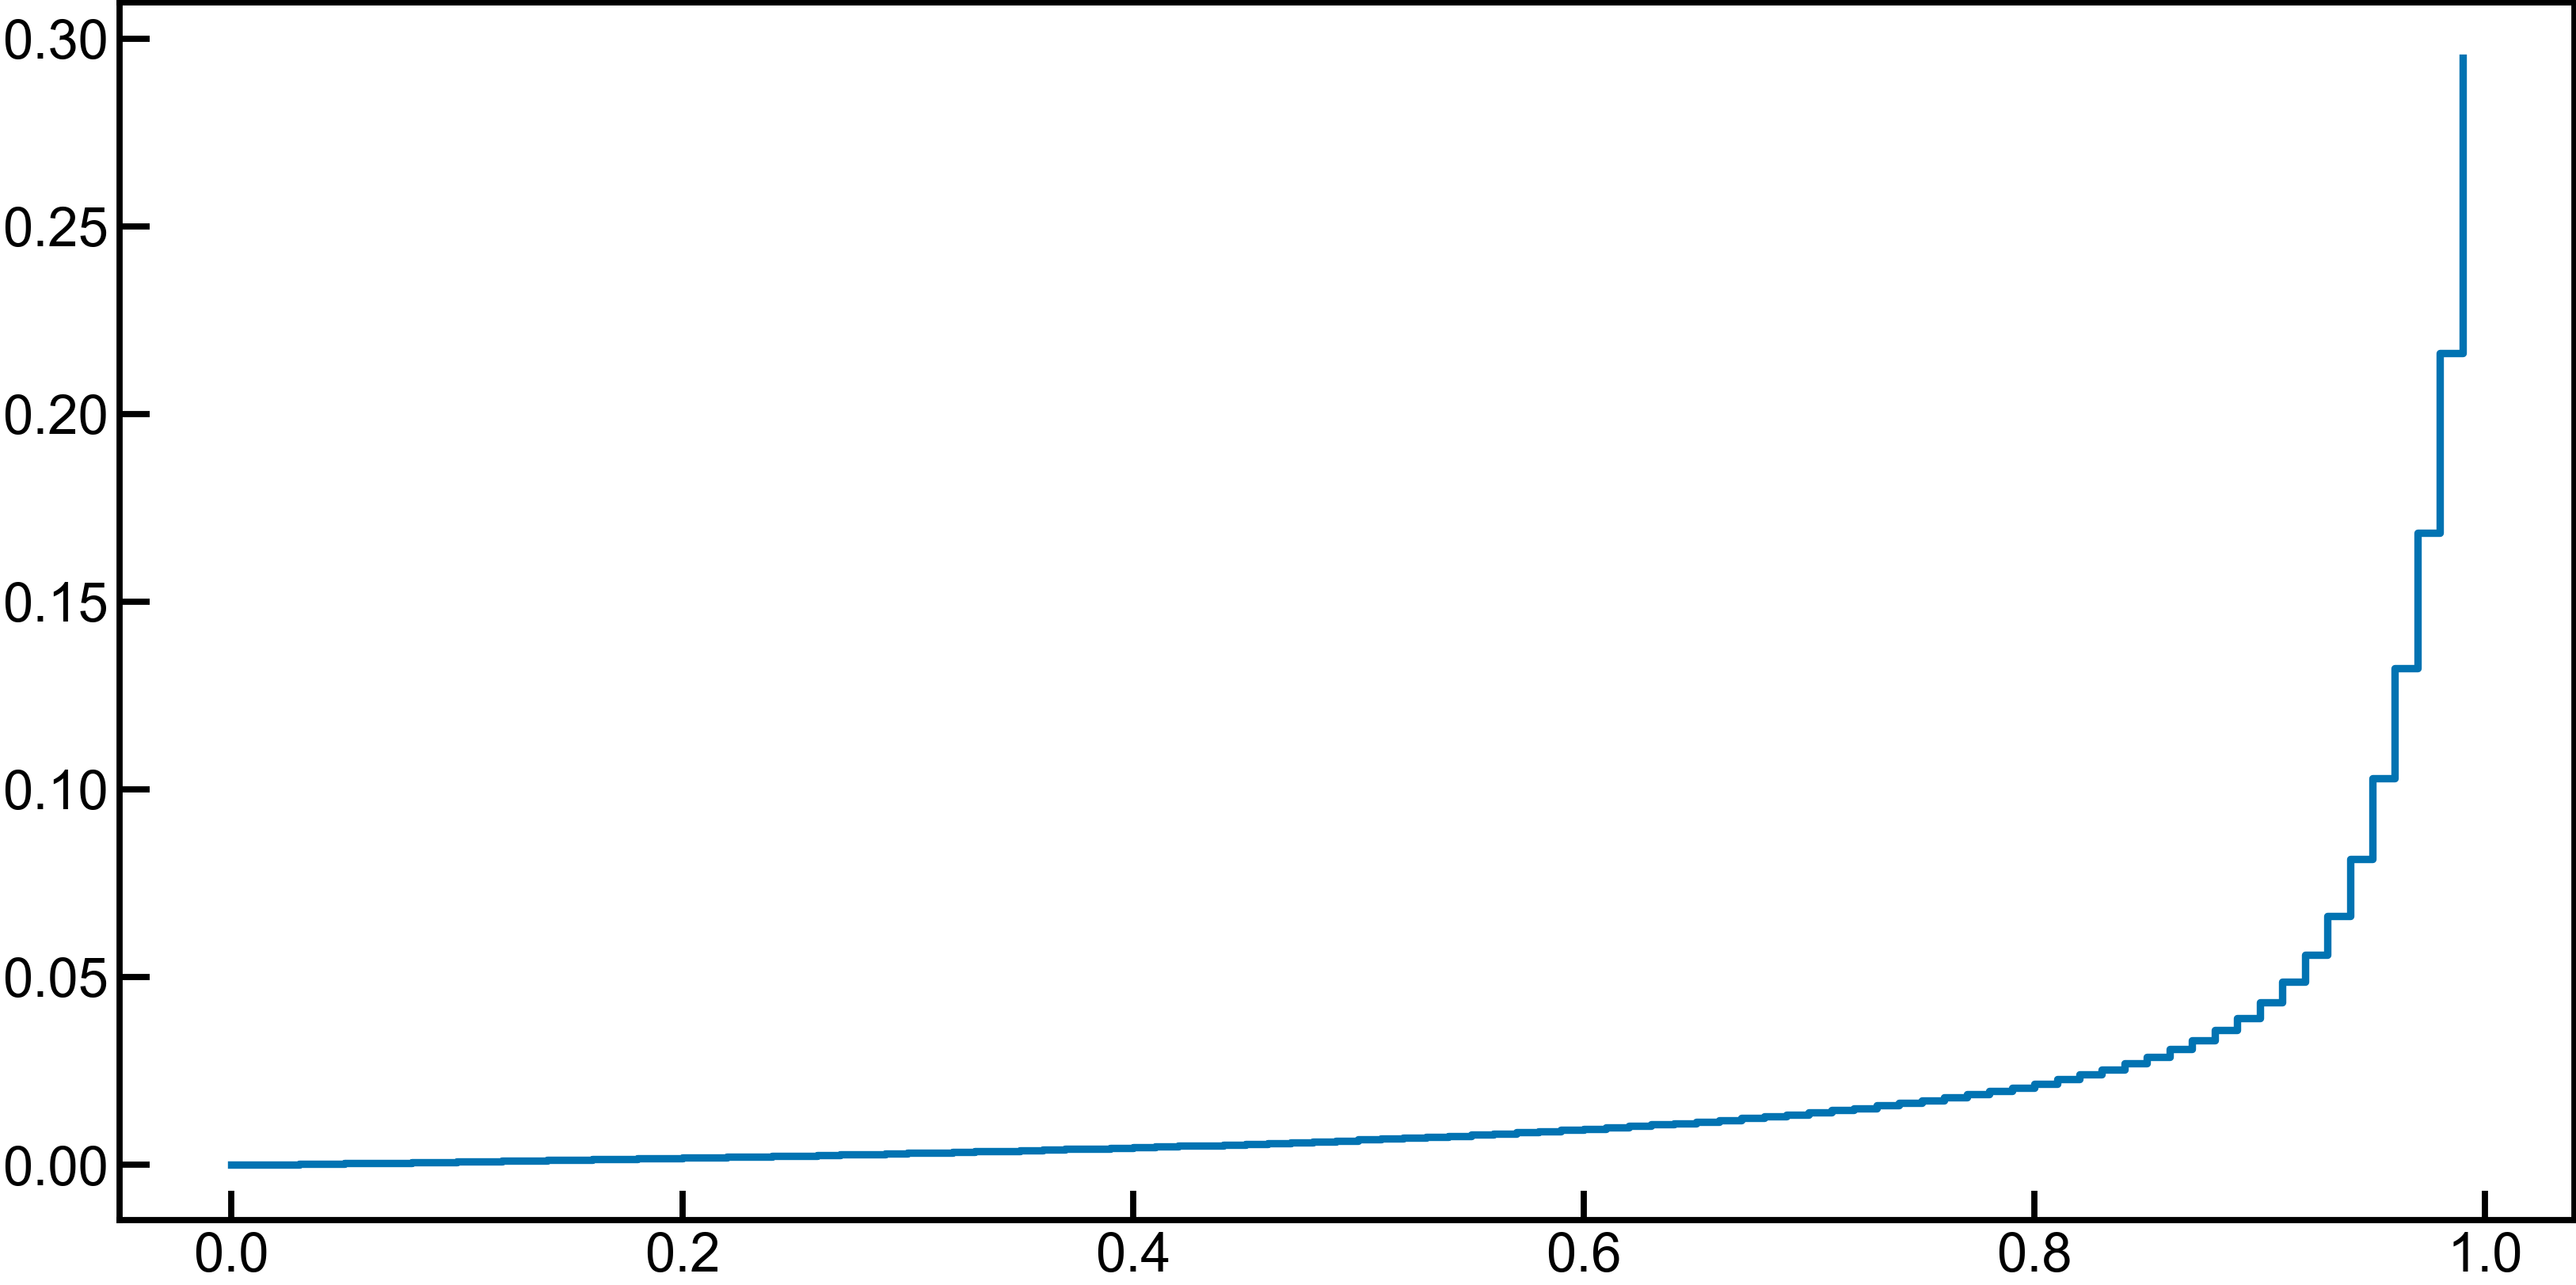

In [6]:
if not check_if_in_h5(logger.filename, "training/grads"):
    optimizer = maskedAdam(m.parameters(), lr=1e-2)
    for i in tqdm(range(2100)):
        x = static_dataset["xn"][i].unsqueeze(0)
        u = static_dataset["u"][i].unsqueeze(0)
        y = static_dataset["y"][i].unsqueeze(0)
        y_pred = m(x, u)
        loss = torch.nn.MSELoss()(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        grads = optimizer._get_flat_grads().detach().cpu().numpy()
        logger.log_value("training/grads", grads)

quantiles = np.linspace(0, 1, 101)[:-1]
grads = np.abs(logger.get_dataset("training/grads"))
quantile_values = [np.quantile(grads, q) for q in quantiles]

if 1:
    fig, ax = plt.subplots(figsize=(13.33, 6.66), dpi=300)
    ax.step(quantiles, quantile_values, where="post")

grad_thresh = quantile_values[-1]
print(f"Gradient Threshold (99): {grad_thresh:.2e}")
print(f"Gradient Threshold (95): {quantile_values[-5]:.2e}")

generate drifting data

In [7]:
if not check_if_in_h5(logger.filename, "updating/values/x"):
    # generate sim_drifting_data
    sim_drifting_data = sim(dXdt_drifting, process_tspan, process_x0, process_u, noise=process_noise)
    logger.log_value("updating/values/x", sim_drifting_data["X"])
    logger.log_value("updating/values/x_scaled", Xscaler.transform(sim_drifting_data["X"]))
    logger.log_value("updating/values/y", sim_drifting_data["Y"])
    logger.log_value("updating/values/y_scaled", Xscaler.transform(sim_drifting_data["Y"]))
    logger.log_value("updating/values/u", sim_drifting_data["U"])
    logger.log_value("updating/values/u_scaled", Uscaler.transform(sim_drifting_data["U"].reshape(-1, 1)))
else:
    sim_drifting_data = {
        "X": logger.get_dataset("updating/values/x")[0],
        "Y": logger.get_dataset("updating/values/y")[0],
        "U": logger.get_dataset("updating/values/u").T,
    }
drifting_dataset = format_dataset(sim_drifting_data, Xscaler, Uscaler, begin_index=0, end_index=-1, nx=nx, input_horizon=input_horizon, train=False, name="drifting", device=device)

In [8]:
# graph the species concentrations for static and drifting systems
if 1:    
    ### graph the species concentrations for static and drifting systems ###
    species_labels = [r"$C_A$", r"$C_B$", r"$C_C$"]
    y_ticks_formatter = mpl.ticker.StrMethodFormatter("{x:,.2f}")
    y_tick_major_locator = MaxNLocator(3)
    y_tick_minor_locator = MaxNLocator(9)
    t_graph = np.arange(sim_5_data["Y"].shape[0])

    fig, ax = plt.subplots(4, 1, figsize=(13.33, 5.75), sharex=True, dpi=300)
    for species in range(3):
        static, = ax[species].plot(t_graph, sim_5_data["Y"][:, species], color=true_colors[0], linestyle="-", zorder=1)
        drifting, = ax[species].plot(t_graph, sim_drifting_data["Y"][:, species], color=emph_colors[0], linestyle="-", zorder=1)
        
        ax[species].set_ylim(0.17, 0.6)
        ax[species].yaxis.set_major_locator(y_tick_major_locator)
        ax[species].yaxis.set_minor_locator(y_tick_minor_locator)
        ax[species].set_ylabel(species_labels[species])
        ax[species].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.2f}"))
        ax[species].set_xlim(0, t_graph[-1])
    # graph U
    ax[-1].plot(t_graph, sim_5_data["U"], color=true_colors[0], linestyle="-", zorder=1)
    ax[-1].set_ylabel(r"U ($C_{Af}$)")
    ax[-1].set_xlabel("Hours")
    ax[-1].set_xticks(np.arange(0, t_graph[-1]+120, 120), labels=[str(int(i)) for i in np.arange(0, t_graph[-1]+120, 120) / 60])
    ax[-1].set_xticks(np.arange(0, t_graph[-1], 15), minor=True)
    ax[-1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.2f}"))
    ax[-1].set_ylim(1, 3)
    ax[-1].set_xlim(0, t_graph[-1])

    ax[-1].legend([static, drifting], ["Static Process", "Drifting Process"], loc="upper center", bbox_to_anchor=(0.5, -0.55), ncol=2)

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.1)

    fig.savefig(os.path.join(results_dir, "Drifting Concentrations.png"))
    fig.savefig(os.path.join(results_dir, "Drifting Concentrations.svg"))
    plt.close()

    ### graph the species concentrations for static and drifting systems ###
    species_labels = [i + " (scaled)" for i in [r"$C_A$", r"$C_B$", r"$C_C$"]]
    y_ticks_formatter = mpl.ticker.StrMethodFormatter("{x:,.2f}")
    t_graph = np.arange(sim_5_data["Y"].shape[0])

    static_X = Xscaler.transform(sim_5_data["Y"])
    static_U = Uscaler.transform(sim_5_data["U"].reshape(-1, 1))
    drifting_X = Xscaler.transform(sim_drifting_data["Y"])
    drifting_U = Uscaler.transform(sim_drifting_data["U"].reshape(-1, 1))

    fig, ax = plt.subplots(4, 1, figsize=(13.33, 5.75), sharex=True, dpi=300)
    for species in range(3):
        static, = ax[species].plot(t_graph, static_X[:, species], color=true_colors[0], linestyle="-", zorder=1)
        drifting, = ax[species].plot(t_graph, drifting_X[:, species], color=emph_colors[0], linestyle="-", zorder=1)
        
        ax[species].set_yticks([-2.5, 0, 2.5])
        ax[species].set_yticks(np.arange(-3.5, 3, 0.5), minor=True)
        ax[species].set_ylabel(species_labels[species])
        ax[species].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.2f}"))
        ax[species].set_xlim(0, t_graph[-1])
    # graph U
    ax[-1].plot(t_graph, sim_5_data["U"], color=true_colors[0], linestyle="-", zorder=1)
    ax[-1].set_ylabel(r"U ($C_{Af}$)")
    ax[-1].set_xlabel("Hours")
    ax[-1].set_xticks(np.arange(0, t_graph[-1]+120, 120), labels=[str(int(i)) for i in np.arange(0, t_graph[-1]+120, 120) / 60])
    ax[-1].set_xticks(np.arange(0, t_graph[-1], 15), minor=True)
    ax[-1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.2f}"))
    # ax[-1].set_ylim(1, 3)
    ax[-1].set_xlim(0, t_graph[-1])

    ax[-1].legend([static, drifting], ["Static Process", "Drifting Process"], loc="upper center", bbox_to_anchor=(0.5, -0.55), ncol=2)

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.1)

    fig.savefig(os.path.join(results_dir, "Drifting Concentrations (scaled).png"))
    fig.savefig(os.path.join(results_dir, "Drifting Concentrations (scaled).svg"))
    plt.close()

control predictions

In [9]:
updating_prefix = "updating/"
# control
prefix = updating_prefix + "control/"
if not check_if_in_h5(logger.filename, f"{prefix}yp"):
    model = Exogenous_RkRNN(nx, nu, 16)
    model.load_state_dict(torch.load(static_model_save_path, map_location=device, weights_only=True))
    model.to(device)

    optimizer = maskedAdam(model.parameters(), lr=1e-3)  # used to get gradients
    
    start_time = time.time()

    for i in tqdm(range(2100)):
        x = drifting_dataset["xn"][i].unsqueeze(0)
        u = drifting_dataset["u"][i].unsqueeze(0)
        y = drifting_dataset["y"][i].unsqueeze(0)
        y_pred = model(x, u)
        loss = torch.nn.MSELoss()(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        grads = optimizer._get_flat_grads()

        logger.log_dict({
            f"{prefix}yp": y_pred.detach().cpu().numpy(),
            f"{prefix}loss": np.array([loss.item()]),
            f"{prefix}grads": grads.cpu().numpy(),
            f"{prefix}time": np.array([time.time() - start_time]),
            # f"{prefix}jac": jac.cpu().numpy()
        })

  0%|          | 0/2100 [00:00<?, ?it/s]

adam

In [10]:
updating_prefix = "updating/"

def adam_updating(prefix, lr=1e-3, loss_threshold=0.04, retraining_moving_horizon_length=50, **mask_func_kwargs):
    """ Update orginal model with Adam optimizer 
    ARGS:
        prefix: str
            prefix for the data
        loss_threshold: float
            threshold for the loss to trigger the retraining iterations
        retraining_moving_horizon_length: int
            number of previous data points to consider for retraining
        mask_func_kwargs: dict
            kwargs for the mask function.
            (none): all parameters
            quantile_thresh: threshold for the quantile mask
            thresh: gradient threhsold
    """
    if not check_if_in_h5(logger.filename, f"{prefix}yp"):
        logger.log_dict({
            f"{prefix}parameters/lr": np.array([lr]),
            f"{prefix}parameters/loss_threshold": np.array([loss_threshold]),
            f"{prefix}parameters/retraining_moving_horizon_length": np.array([retraining_moving_horizon_length]),
            })
        # mask func kwargs if any
        for k,v in mask_func_kwargs.items():
            logger.log_value(f"{prefix}parameters/{k}", np.array([v]))
        
        model = Exogenous_RkRNN(nx, nu, 16)
        model.load_state_dict(torch.load(static_model_save_path, map_location=device, weights_only=True))
        model.to(device)

        optimizer = maskedAdam(model.parameters(), lr=lr)
        
        logger.log_value(f"{prefix}loss_threshold", np.array([loss_threshold]))
        
        start_time = time.time()

        for i in tqdm(range(2100), desc=prefix):
            x = drifting_dataset["xn"][i].unsqueeze(0)
            u = drifting_dataset["u"][i].unsqueeze(0)
            y = drifting_dataset["y"][i].unsqueeze(0)
            y_pred = model(x, u)
            loss = torch.nn.MSELoss()(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            grads = optimizer._get_flat_grads()
            mask = mask_fn(grads, **mask_func_kwargs)
            
            if loss.item() > loss_threshold:
                j = 0 if i < retraining_moving_horizon_length else i-retraining_moving_horizon_length
                retraining_indices = np.arange(j, i)
                for sub_batch in range(50):
                    sub_batch_indices = default_rng.choice(retraining_indices, size=5, replace=True)
                    sub_x = drifting_dataset["xn"][sub_batch_indices]
                    sub_u = drifting_dataset["u"][sub_batch_indices]
                    sub_y = drifting_dataset["y"][sub_batch_indices]
                    sub_y_pred = model(sub_x, sub_u)
                    sub_loss = torch.nn.MSELoss()(sub_y_pred, sub_y)
                    optimizer.zero_grad()
                    sub_loss.backward()
                    sub_grads = optimizer._get_flat_grads()
                    optimizer.masked_step(mask=mask)

            logger.log_dict({
                f"{prefix}yp": y_pred.detach().cpu().numpy(),
                f"{prefix}loss": np.array([loss.item()]),
                f"{prefix}grads": grads.cpu().numpy(),
                f"{prefix}time": np.array([time.time() - start_time]),
                # f"{prefix}jac": jac.cpu().numpy()
            })

lr=1e-3
        
# adam-all
adam_updating(updating_prefix + f"adam-all/{lr}/", lr=lr)
# adam-q99
adam_updating(updating_prefix + f"adam-quantile-0.99/{lr}/", lr=lr, quantile_thresh=0.99)
# adam-q95
adam_updating(updating_prefix + f"adam-quantile-0.95/{lr}/", lr=lr, quantile_thresh=0.95)
# adam-th99
adam_updating(updating_prefix + f"adam-thresh-0.99/{lr}/", lr=lr, thresh=quantile_values[-1])
# adam-th95
adam_updating(updating_prefix + f"adam-thresh-0.95/{lr}/", lr=lr, thresh=quantile_values[-5])

updating/adam-all/0.001/:   0%|          | 0/2100 [00:00<?, ?it/s]

BlockingIOError: [Errno 35] Unable to open file (unable to lock file, errno = 35, error message = 'Resource temporarily unavailable')

KF updating

In [9]:
def kf_updating(prefix, lr=3e-4, q=0.1, p0=100, **mask_func_kwargs):

    if not check_if_in_h5(logger.filename, f"{prefix}yp"):
        logger.log_dict({
            f"{prefix}parameters/lr": np.array([lr]),
            f"{prefix}parameters/q": np.array([q]),
            f"{prefix}parameters/p0": np.array([p0]),
            })
        # mask func kwargs if any
        for k,v in mask_func_kwargs.items():
            logger.log_value(f"{prefix}parameters/{k}", np.array([v]))
        
        model = Exogenous_RkRNN(nx, nu, 16)
        model.load_state_dict(torch.load(static_model_save_path, map_location=device, weights_only=True))
        model.to(device)

        optimizer = GEKF(model.parameters(), lr=lr, q=q, p0=p0)
        
        start_time = time.time()

        for i in tqdm(range(2100), desc=prefix):
            x = drifting_dataset["xn"][i].unsqueeze(0)
            u = drifting_dataset["u"][i].unsqueeze(0)
            y = drifting_dataset["y"][i].unsqueeze(0)
            y_pred = model(x, u)
            loss = torch.nn.MSELoss()(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            grads = optimizer._get_flat_grads()
            jac = get_jacobian(model, (x, u))
            mask = mask_fn(grads, **mask_func_kwargs)
            optimizer.step(y-y_pred, jac, mask=mask)

            logger.log_dict({
                f"{prefix}yp": y_pred.detach().cpu().numpy(),
                f"{prefix}loss": np.array([loss.item()]),
                f"{prefix}grads": grads.cpu().numpy(),
                f"{prefix}time": np.array([time.time() - start_time]),
                # f"{prefix}jac": jac.cpu().numpy()
            })
        
# kf-all
kf_updating(updating_prefix + "kf-all/")
# kf-q99
kf_updating(updating_prefix + "kf-quantile-0.99/", q=0.99)
# kf-q95
kf_updating(updating_prefix + "kf-quantile-0.95/", q=0.95)
# kf-th99
kf_updating(updating_prefix + "kf-thresh-0.99/", thresh=quantile_values[-1])
# kf-th95
kf_updating(updating_prefix + "kf-thresh-0.95/", thresh=quantile_values[-5])

updating/kf-all/:   0%|          | 0/2100 [00:00<?, ?it/s]

updating/kf-quantile-0.99/:   0%|          | 0/2100 [00:00<?, ?it/s]

updating/kf-quantile-0.95/:   0%|          | 0/2100 [00:00<?, ?it/s]

updating/kf-thresh-0.99/:   0%|          | 0/2100 [00:00<?, ?it/s]

updating/kf-thresh-0.95/:   0%|          | 0/2100 [00:00<?, ?it/s]

## Plots

In [16]:
dataset = "test"
index = 0

u = Uscaler.inverse_transform(logger.get_dataset(f"training/values/{dataset}/u")[-1, index])
x = Xscaler.inverse_transform(logger.get_dataset(f"training/values/{dataset}/xn")[-1, index])
y = Xscaler.inverse_transform(logger.get_dataset(f"training/values/{dataset}/y")[-1, index])
y_pred = Xscaler.inverse_transform(logger.get_dataset(f"training/values/{dataset}/yp")[-1, index])

fig, ax = plt.subplots(4, 1, figsize=(13.33/3*2, 6.63), sharex=True, dpi=300)
for species in range(3):
    true = ax[species].scatter(np.arange(1, prediction_horizon+1), y[:, species], color=true_colors[0], zorder=1)
    pred,  = ax[species].plot(np.arange(1, prediction_horizon+1), y_pred[:, species], color=model_colors[0],  zorder=1)
    initial = ax[species].scatter(0, x[:,species], color="k", zorder=1)
    ax[species].set_ylim(np.min(y)-0.02, np.max(y)+0.02)
    # ax[species].set_yticks(np.arange(0.15, 0.45, 0.05))
    ax[species].yaxis.set_major_locator(MaxNLocator(4))
    ax[species].yaxis.set_major_formatter(y_ticks_formatter)
    ax[species].set_xticks(np.arange(0, 70, 10))
    ax[species].set_xticks(np.arange(0, 61, 1), minor=True)
    ax[species].set_ylabel(species_labels[species])
    ax[species].yaxis.set_major_formatter(y_ticks_formatter)
    ax[species].set_xlim(-0.5, prediction_horizon+0.5)

# graph U
ax[-1].scatter(np.arange(0, prediction_horizon), u, color="k", zorder=1)
ax[-1].set_ylim(0.9, 3.1)
ax[-1].yaxis.set_major_formatter(y_ticks_formatter)
ax[-1].set_ylabel(r"U ($C_{Af}$)")
ax[-1].set_xlabel("Prediction Horizon (Minutes)")

ax[-1].legend([initial, true, pred], ["Known Inputs", "True", "Model Prediction"],
    loc="upper left", bbox_to_anchor=(-0.15, -0.42), ncol=3)

fig.tight_layout()

fig.savefig(os.path.join(static_process_dir, f"Constant Model - {dataset} - Individual Prediction narrow.png"))
fig.savefig(os.path.join(static_process_dir, f"Constant Model - {dataset} - Individual Prediction narrow.svg"))
plt.close()

updating loss lineplot

In [17]:
l1 = logger.get_dataset("updating/adam-all/loss")
# l2 = logger.get_dataset("updating/adam-quantile-0.95/loss")
# l3 = logger.get_dataset("updating/adam-thresh-0.99/loss")
l4 = logger.get_dataset("updating/kf-all/loss")
l5 = logger.get_dataset("updating/kf-quantile-0.99/loss")
l5_2 = logger.get_dataset("updating/kf-quantile-0.95/loss")
l6 = logger.get_dataset("updating/kf-thresh-0.99/loss")
l6_2 = logger.get_dataset("updating/kf-thresh-0.95/loss")

fig, ax = plt.subplots(figsize=(13.33, 4.5), dpi=300)
k2r = 1e-1 + 3e-5 * np.linspace(0, 2100, 2100)

ax.plot(k2r, l1, color=adam_colors[0], label="Retraining (All)")
# ax.plot(k2r, l2, color=adam_colors[1], label="Adam (Quantile 0.95)")
# ax.plot(k2r, l3, color=adam_colors[2], label="Adam (Threshold 0.99)")   
ax.plot(k2r, l4, color=kalman_colors[0], label="Kalman (All)")
# ax.plot(k2r, l5, color=kalman_colors[1], label="Kalman (Quantile 0.99)")
# ax.plot(k2r, l5_2, color=kalman_colors[1], label="Kalman (Quantile 0.95)", linestyle="--")
# ax.plot(k2r, l6, color=kalman_colors[2], label="Kalman (Threshold 0.99)")
# ax.plot(k2r, l6_2, color=kalman_colors[2], label="Kalman (Threshold 0.95)", linestyle="--")

ax.hlines(0.04, k2r[0], k2r[-1], color="black", linestyle="--", linewidth=1)
ax.text(0.1005, 0.04, "Retraining Threshold", verticalalignment="bottom", horizontalalignment="left")

ax.set_ylim(0, 0.055)
ax.set_xlim(k2r[0]-0.001, k2r[-1]+0.001)
ax.set_ylabel("Mean Squared Error (Scaled)")
ax.set_xlabel(r"$k_{2r}$ Reaction Constant")

ax.legend(loc="upper right", ncol=2, title="Method (Parameters Updated)")

fig.savefig(os.path.join(results_dir, "Updating Loss.png"))
fig.savefig(os.path.join(results_dir, "Updating Loss.svg"))
fig.savefig(os.path.join(results_dir, "Updating Loss.pdf"))
plt.close()

In [22]:
# times are cumulative so take the difference
adam_all_loss = logger.get_dataset("updating/adam-all/loss")
adam_all_time = np.diff(logger.get_dataset("updating/adam-all/time"),axis=0, prepend=0)
adam_q99_loss = logger.get_dataset("updating/adam-quantile-0.99/loss")
adam_q99_time = np.diff(logger.get_dataset("updating/adam-quantile-0.99/time"),axis=0, prepend=0)
adam_q95_loss = logger.get_dataset("updating/adam-quantile-0.95/loss")
adam_q95_time = np.diff(logger.get_dataset("updating/adam-quantile-0.95/time"),axis=0, prepend=0)
adam_t99_loss = logger.get_dataset("updating/adam-thresh-0.99/loss")
adam_t99_time = np.diff(logger.get_dataset("updating/adam-thresh-0.99/time"),axis=0, prepend=0)
adam_t95_loss = logger.get_dataset("updating/adam-thresh-0.95/loss")
adam_t95_time = np.diff(logger.get_dataset("updating/adam-thresh-0.95/time"),axis=0, prepend=0)
kf_all_loss = logger.get_dataset("updating/kf-all/loss")
kf_all_time = np.diff(logger.get_dataset("updating/kf-all/time"),axis=0, prepend=0)
kf_q99_loss = logger.get_dataset("updating/kf-quantile-0.99/loss")
kf_q99_time = np.diff(logger.get_dataset("updating/kf-quantile-0.99/time"),axis=0, prepend=0)
kf_q95_loss = logger.get_dataset("updating/kf-quantile-0.95/loss")
kf_q95_time = np.diff(logger.get_dataset("updating/kf-quantile-0.95/time"),axis=0, prepend=0)
kf_t99_loss = logger.get_dataset("updating/kf-thresh-0.99/loss")
kf_t99_time = np.diff(logger.get_dataset("updating/kf-thresh-0.99/time"),axis=0, prepend=0)
kf_t95_loss = logger.get_dataset("updating/kf-thresh-0.95/loss")
kf_t95_time = np.diff(logger.get_dataset("updating/kf-thresh-0.95/time"),axis=0, prepend=0)

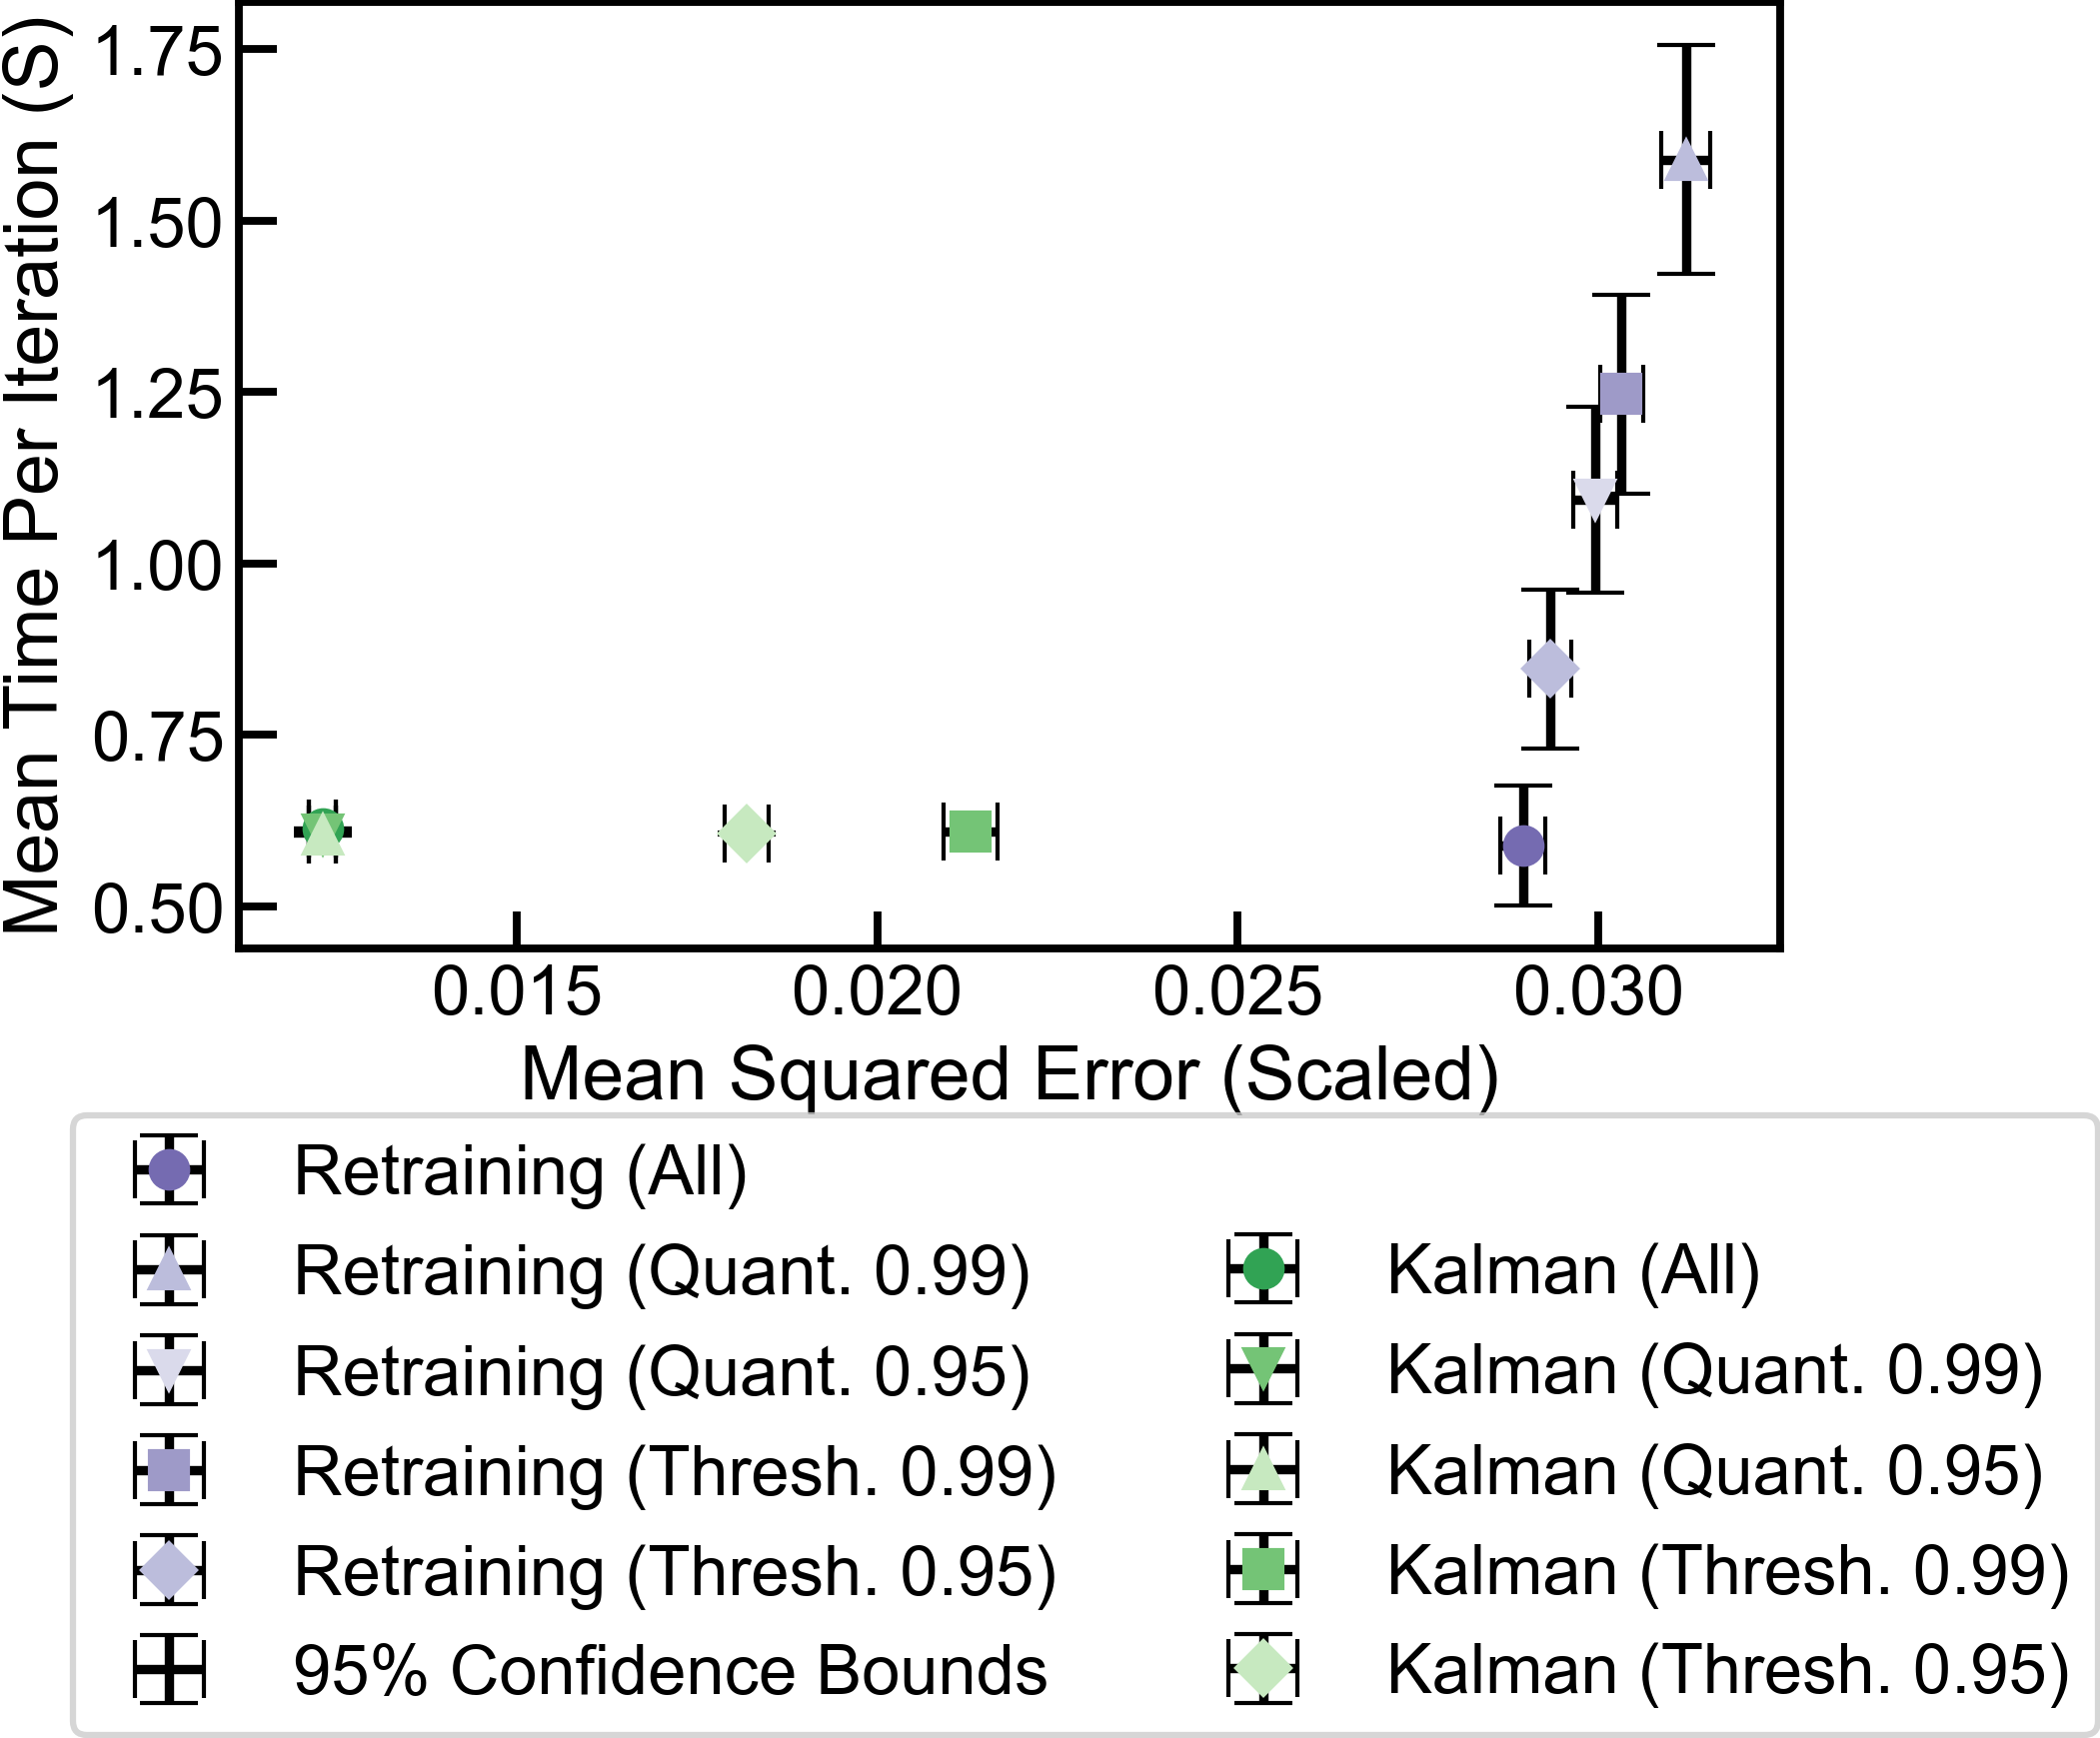

In [25]:
fig, ax = plt.subplots(figsize=(6.63, 4.1), dpi=300)
plot_ci(adam_all_loss, adam_all_time, ax=ax, color=adam_colors[0], label="Retraining (All)")
plot_ci(adam_q99_loss, adam_q99_time, ax=ax, color=adam_colors[2], label="Retraining (Quant. 0.99)", marker_fmt="^")
plot_ci(adam_q95_loss, adam_q95_time, ax=ax, color=adam_colors[3], label="Retraining (Quant. 0.95)", marker_fmt="v")
plot_ci(adam_t99_loss, adam_t99_time, ax=ax, color=adam_colors[1], label="Retraining (Thresh. 0.99)", marker_fmt="s")
plot_ci(adam_t95_loss, adam_t95_time, ax=ax, color=adam_colors[2], label="Retraining (Thresh. 0.95)", marker_fmt="D")
plot_ci(kf_all_loss, kf_all_time, ax=ax, color="none", label="95% Confidence Bounds", marker_fmt="")
ax.errorbar(np.nan, np.nan, yerr=np.nan, color="none", label=" ")
plot_ci(kf_all_loss, kf_all_time, ax=ax, color=kalman_colors[0], label="Kalman (All)")
plot_ci(kf_q99_loss, kf_q99_time, ax=ax, color=kalman_colors[1], label="Kalman (Quant. 0.99)", marker_fmt="v")
plot_ci(kf_q95_loss, kf_q95_time, ax=ax, color=kalman_colors[3], label="Kalman (Quant. 0.95)", marker_fmt="^")
plot_ci(kf_t99_loss, kf_t99_time, ax=ax, color=kalman_colors[1], label="Kalman (Thresh. 0.99)", marker_fmt="s")
plot_ci(kf_t95_loss, kf_t95_time, ax=ax, color=kalman_colors[3], label="Kalman (Thresh. 0.95)", marker_fmt="D")

ax.set_xlabel("Mean Squared Error (Scaled)")
ax.set_ylabel("Mean Time Per Iteration (S)")
ax.legend(loc="upper left", ncol=2, bbox_to_anchor=(-0.13, -.14))
# ax.set_yscale("log")
# ax.set_xscale("log")
# fig.tight_layout()
# ax.set_ylim(0, 110)

# fig.savefig(os.path.join(results_dir, "Updating Loss-time.png"))
# fig.savefig(os.path.join(results_dir, "Updating Loss-time.svg"))
# fig.savefig(os.path.join(results_dir, "Updating Loss-time.pdf"))
# plt.close()

In [ ]:
# table of mean loss, time, and ci bounds


In [18]:
prediction_index = 1100
k2r = 1e-1 + 3e-5 * prediction_index

### graph individual prediction ###
# args
# logger

u = Uscaler.inverse_transform(logger.get_dataset("updating/control/u")[prediction_index, 0])
y = Xscaler.inverse_transform(logger.get_dataset("updating/control/y")[prediction_index, 0])
x = Xscaler.inverse_transform(logger.get_dataset("updating/control/x")[prediction_index, 0])

y_ = logger.get_dataset("updating/control/y")[prediction_index, 0]
yp_control_ = logger.get_dataset("updating/control/yp")[prediction_index, 0]
yp_adam_all_ = logger.get_dataset("updating/adam-all/yp")[prediction_index, 0]
yp_kf_all_ = logger.get_dataset("updating/kf-all/yp")[prediction_index, 0]

yp_control = Xscaler.inverse_transform(yp_control_)
yp_adam_all = Xscaler.inverse_transform(yp_adam_all_)
yp_kf_all = Xscaler.inverse_transform(yp_kf_all_)

In [19]:
fig, ax = plt.subplots(4, 1, figsize=(11, 5.5), sharex=True, dpi=300)
y_ticks_formatter = mpl.ticker.StrMethodFormatter("{x:,.2f}")
species_labels = [r"$C_A$", r"$C_B$", r"$C_C$"]
for species in range(3):
    true = ax[species].scatter(np.arange(1, prediction_horizon+1), y[:, species], color=true_colors[0], zorder=1)
    control,  = ax[species].plot(np.arange(1, prediction_horizon+1), yp_control[:, species], color=model_colors[0], linestyle=":",  zorder=1)
    adam, = ax[species].plot(np.arange(1, prediction_horizon+1), yp_adam_all[:, species], color=adam_colors[0],  zorder=1)
    kf, = ax[species].plot(np.arange(1, prediction_horizon+1), yp_kf_all[:, species], color=kalman_colors[0],  zorder=1)
    initial = ax[species].scatter(0, x[:,species], color="k", zorder=1)
    # ax[species].set_ylim(np.min(y)-0.02, np.max(y)+0.02)
    # ax[species].set_yticks(np.arange(0.15, 0.45, 0.05))
    ax[species].yaxis.set_major_locator(MaxNLocator(4))
    ax[species].yaxis.set_major_formatter(y_ticks_formatter)
    ax[species].set_xticks(np.arange(0, 70, 10))
    ax[species].set_xticks(np.arange(0, 61, 1), minor=True)
    ax[species].set_ylabel(species_labels[species])
    ax[species].yaxis.set_major_formatter(y_ticks_formatter)
    ax[species].set_xlim(-0.5, prediction_horizon+0.5)

# graph U
ax[-1].scatter(np.arange(0, prediction_horizon), u, color="k", zorder=1)
ax[-1].set_ylim(0.9, 3.1)
ax[-1].yaxis.set_major_formatter(y_ticks_formatter)
ax[-1].set_ylabel(r"U ($C_{Af}$)")
ax[-1].set_xlabel("Prediction Horizon (Minutes)")

# ax[-1].legend([initial, true, control, adam, kf], ["Known Inputs", "True", "Original Model", "Adam (All)", "Kalman (All)"], loc="upper center", bbox_to_anchor=(0.5, -0.65), ncol=5)
fig.legend([initial, true, control, adam, kf], ["Known Inputs", "True", "Original Model", "Adam (All)", "Kalman (All)"], loc="upper left", bbox_to_anchor=(0.98, 0.95), ncol=1)
fig.text(0.98, 0.5, r"$\bf MSE (Scaled)$"+f"\nOriginal Model: {np.mean((y_-yp_control_)**2):.3f}\nAdam (All): {np.mean((y_-yp_adam_all_)**2):.3f}\nKalman (All): {np.mean((y_-yp_kf_all_)**2):.3f}\n\n"+r"$K_{2r}$:0.1$\rightarrow$"+f"{k2r:.3f}", verticalalignment="top", horizontalalignment="left")

fig.tight_layout()

fig.savefig(os.path.join(results_dir, f"Drifting - Individual Prediction - legendR.png"))
fig.savefig(os.path.join(results_dir, f"Drifting - Individual Prediction - legendR.svg"))
plt.close()